In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# import mne
import numpy as np
# from copy import deepcopy
# import matplotlib.pyplot as plt
import sys; sys.path.insert(0, '../')
from esinet import util
from esinet import Simulation
from esinet import Net
from esinet.forward import create_forward_model, get_info
from scipy.stats import pearsonr
from matplotlib import pyplot as plt
plot_params = dict(surface='white', hemi='both', verbose=0)

## Create Forward model
First we create a template forward model which comes with the esinet package

In [2]:
info = get_info(sfreq=100, kind="biosemi64")
fwd = create_forward_model(sampling="ico3", info=info)
_, pos = util.unpack_fwd(fwd)[1:3]
leadfield = fwd["sol"]["data"]
n_chans, n_dipoles = leadfield.shape

import mne
from scipy.sparse.csgraph import laplacian

adjacency = mne.spatial_src_adjacency(fwd['src']).toarray()
laplace_operator = abs(laplacian(adjacency))

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    4.6s remaining:    7.8s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    5.2s remaining:    3.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished


-- number of adjacent vertices : 1284


# Defs

In [3]:
import tensorflow as tf
def prep_data(X, y):
    X = np.stack([(x - np.mean(x)) / np.std(x) for x in X], axis=0)
    y = np.stack([(x / np.max(abs(x))) for x in y], axis=0)
    return X, y

def data_loss(x, y, ord=2):
    return np.linalg.norm(x-y, ord=ord)

def l1_norm(x):
    return np.linalg.norm(x, ord=1)
def l1_l2(x):
    return np.linalg.norm(x, ord=1) / np.linalg.norm(x, ord=2)
def temporal_reg(x):
    return np.std(abs(x), axis=1)

def compute_cosine_distances(a, b):
    # x shape is n_a * dim
    # y shape is n_b * dim
    # results shape is n_a * n_b

    normalize_a = tf.nn.l2_normalize(a,-1)        
    normalize_b = tf.nn.l2_normalize(b,-1)
    distance = 1 - tf.matmul(normalize_a, normalize_b, transpose_b=True)
    return distance

# Simulate

In [9]:
settings = dict(duration_of_trial=0.01, extents=(1,40), number_of_sources=(1,15), target_snr=1e99)
sim = Simulation(fwd, info, settings=settings).simulate(n_samples=2)
y = np.stack([eeg.average().data for eeg in sim.eeg_data], axis=0)
x = np.stack([source.data for source in sim.source_data], axis=0)
x = x[0, :, 0]
y = y[0, :, 0]
sim.source_data[0].plot(**plot_params)

Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00, 285.96it/s]


# Solve

## Create

In [21]:
np.linalg.norm(leadfield @ src_hat_1 - y)

200.38944964902558

In [26]:
from scipy.optimize import minimize

print(x.shape, y.shape)
constr = dict(type="eq", fun=lambda x: np.linalg.norm(leadfield @ x - y)*1000)
options = dict(maxiter=100)
tol = 1e-6
x0 = np.linalg.pinv(leadfield) @ y
res = minimize(l1_l2, x0, method="SLSQP", constraints=constr, options=options, tol=tol)
src_hat_1 = res["x"]

res = minimize(l1_norm, x0, method="SLSQP", constraints=constr, options=options, tol=tol)
src_hat_2 = res["x"]

(1284,) (64,)


KeyboardInterrupt: 

## Evaluate

No projector specified for this dataset. Please consider the method self.add_proj.


c:\Users\lukas\virtualenvs\esienv\lib\site-packages\mne\viz\evoked.py:521: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(xlim)


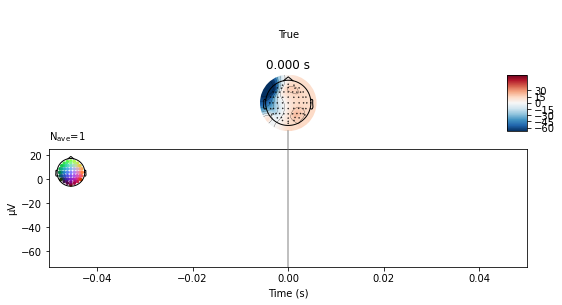

No projector specified for this dataset. Please consider the method self.add_proj.


c:\Users\lukas\virtualenvs\esienv\lib\site-packages\mne\viz\evoked.py:521: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(xlim)


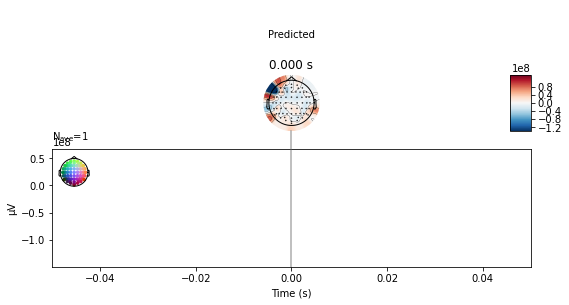

L1-L2-Ratio: AUC:  0.6847205411178354  Corrs:  0.10843118924984745  nMSE:  0.03160206729370715
No projector specified for this dataset. Please consider the method self.add_proj.


c:\Users\lukas\virtualenvs\esienv\lib\site-packages\mne\viz\evoked.py:521: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(xlim)


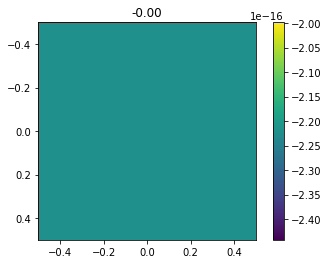

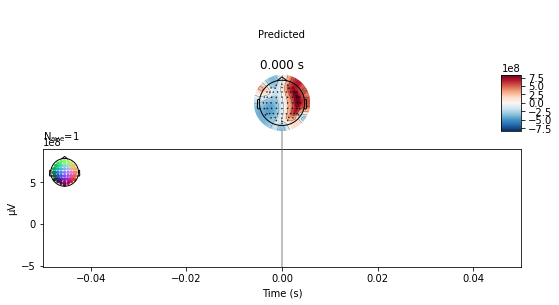

L1-L2-Ratio: AUC:  0.5405695977216092  Corrs:  -0.2706234434528179  nMSE:  0.0416698434220727


In [24]:
from esinet.evaluate import eval_auc
from scipy.stats import pearsonr
idx = 0
stc = sim.source_data[idx].copy()
stc.data /= np.max(abs(stc.data))

stc.plot(**plot_params)
evoked = sim.eeg_data[idx].average()
evoked.plot_joint(title="True",)
stc_hat = stc.copy()
stc_hat.data = src_hat_1[:, np.newaxis]
stc_hat.data /= np.max(abs(stc_hat.data))
stc_hat.plot(**plot_params, brain_kwargs=dict(title="Prediction l1-l2-ratio"))

evoked_ = util.get_eeg_from_source(stc_hat, fwd, info, tmin=evoked.tmin)
evoked_.plot_joint(title=f"Predicted", times=[0,])

auc = np.mean([np.mean(eval_auc(y_true_sample, y_pred_sample, pos)) for y_true_sample, y_pred_sample in zip(stc.data.T, stc_hat.data.T)])
corrs = np.mean([np.mean(pearsonr(y_true_sample, y_pred_sample)[0]) for y_true_sample, y_pred_sample in zip(stc.data.T, stc_hat.data.T)])
nmses = np.mean([np.mean((y_true_sample - y_pred_sample)**2) for y_true_sample, y_pred_sample in zip(stc.data.T, stc_hat.data.T)])

print("L1-L2-Ratio: AUC: ", auc, " Corrs: ", corrs, " nMSE: ", nmses)
mat = compute_cosine_distances(abs(stc_hat.data.T), abs(stc_hat.data.T)).numpy()
plt.figure()
plt.imshow(mat)
plt.colorbar()
plt.title(f"{mat.mean():.2f}")

stc_hat.data = src_hat_2[:, np.newaxis]
stc_hat.data /= np.max(abs(stc_hat.data))
stc_hat.plot(**plot_params, brain_kwargs=dict(title="Prediction L1"))

evoked_ = util.get_eeg_from_source(stc_hat, fwd, info, tmin=evoked.tmin)
evoked_.plot_joint(title=f"Predicted", times=[0,])



auc = np.mean([np.mean(eval_auc(y_true_sample, y_pred_sample, pos)) for y_true_sample, y_pred_sample in zip(stc.data.T, stc_hat.data.T)])
corrs = np.mean([np.mean(pearsonr(y_true_sample, y_pred_sample)[0]) for y_true_sample, y_pred_sample in zip(stc.data.T, stc_hat.data.T)])
nmses = np.mean([np.mean((y_true_sample - y_pred_sample)**2) for y_true_sample, y_pred_sample in zip(stc.data.T, stc_hat.data.T)])

print("L1-L2-Ratio: AUC: ", auc, " Corrs: ", corrs, " nMSE: ", nmses)

# mat = compute_cosine_distances(abs(stc_hat.data.T), abs(stc_hat.data.T)).numpy()
# plt.figure()
# plt.imshow(mat)
# plt.colorbar()
# plt.title(f"{mat.mean():.2f}")

In [ ]:
plt.figure()
plt.imshow(compute_cosine_distances(abs(stc_hat.data.T), abs(stc_hat.data.T)).numpy())
plt.colorbar()

plt.figure()
plt.imshow(compute_cosine_distances(abs(stc.data.T), abs(stc.data.T)).numpy())
plt.colorbar()

In [ ]:
plt.figure()
plt.hist(compute_cosine_distances(abs(stc_hat.data.T), abs(stc_hat.data.T)).numpy().flatten())

plt.figure()
plt.hist(compute_cosine_distances(abs(stc.data.T), abs(stc.data.T)).numpy().flatten())

In [ ]:
sys.path.insert(0, '../../invert/')
from invert.solvers.minimum_norm_estimates import SolverDynamicStatisticalParametricMapping, SolverMinimumNorm
from invert.solvers.wrop import SolverLAURA
from invert.solvers.empirical_bayes import SolverChampagne

# solver = SolverLAURA().make_inverse_operator(fwd)
solver = SolverChampagne().make_inverse_operator(fwd)
# solver = SolverMinimumNorm().make_inverse_operator(fwd)

stc_mne = solver.apply_inverse_operator(sim_test.eeg_data[0].average())
stc_mne.data = stc_mne.data / np.max(abs(stc_mne.data))
stc_mne.plot(**plot_params, brain_kwargs=dict(title=solver.name))
auc = np.mean([np.mean(eval_auc(y_true_sample, y_pred_sample, pos)) for y_true_sample, y_pred_sample in zip(stc.data.T, stc_mne.data.T)])
corrs = np.mean([np.mean(pearsonr(y_true_sample, y_pred_sample)[0]) for y_true_sample, y_pred_sample in zip(stc.data.T, stc_mne.data.T)])
nmses = np.mean([np.mean((y_true_sample - y_pred_sample)**2) for y_true_sample, y_pred_sample in zip(stc.data.T, stc_mne.data.T)])

print(model.name, " AUC: ", auc, " Corrs: ", corrs, " nMSE: ", nmses, "\n")